# TODOs
1. ### <s> Lemmatize input - Good
2. ### <s> Replace CNNs with KAN-CNNs - Won't learn, Revisit last
3. ### Prune and test
4. ### <s> B-spline Finetuning - Best with splines = 3
5. ### CNN operates on whole embedded lvl - test on various depths (3, 9, 27, 81)
6. ### Deeper CNN - 1 + 3 + 5 gram feed into Deep CNN -> KAN 
7. ### <s> Data Augmentation
8. ### Limit Vocab Size
9. ### Try Word2Vec or Glove pre-trained

In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from fastkan import FastKAN as KAN

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#data = pd.read_csv('./imdb.csv')
#data.head()

train = pd.read_csv("./data/imdb_train_original.csv")
test = pd.read_csv("./data/imdb_test.csv")

In [4]:
# print(train.head)
# print(test.head)

In [6]:
# Convert labels to binary
def transform_label(label):
    return 1 if label == 'positive' else 0

train['label'] = train['sentiment'].progress_apply(transform_label)
test['label'] = test['sentiment'].progress_apply(transform_label)

100%|██████████| 10000/10000 [00:00<00:00, 1334745.42it/s]


In [7]:
# # Check for dataset imbalance
# train.sentiment.value_counts()

In [8]:
# # Review token length
# train['token_length'] = train.review.progress_apply(lambda x: len(x.split()))
# train.head()

In [9]:
# data_pos = train[train['label'] == 1]
# print("Positive review length")
# data_pos['token_length'].describe()

In [10]:
# data_neg = train[train['label'] == 0]
# print("Negative review length")
# data_neg['token_length'].describe()

In [11]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [12]:
# Preprocessing
train['clean'] = train.review.progress_apply(preprocess_text)
test['clean'] = test.review.progress_apply(preprocess_text)

100%|██████████| 10000/10000 [00:04<00:00, 2211.90it/s]


In [13]:
# print(train.head())
# print(test.head())

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [15]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text if necessary
    words = text.split()
    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [16]:
train['lemma'] = train['clean'].progress_apply(lemmatize_text)
test['lemma'] = test['clean'].progress_apply(lemmatize_text)

100%|██████████| 10000/10000 [00:02<00:00, 3922.37it/s]


In [17]:
# for n in range(20):
#     print(data['clean'][n])
#     print(data['lemma'][n])

In [18]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 256
#data['tokenized'] = data.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))
train['tokenized'] = train.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))
test['tokenized'] = test.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 10000/10000 [00:05<00:00, 1810.48it/s]


In [19]:
# # Check actual tokenized text len
# data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
# data_pos = data[data['label'] == 1]
# data_pos['ct_length'].describe()

In [20]:
# split the data
# X = data.tokenized
# y = data.label
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
X_train = train.tokenized
y_train = train.label

X_test = test.tokenized
y_test = test.label

# Convert to tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create Datasets - tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [20]:
# Batch the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# import torch
import torch.nn as nn
import torch.nn.functional as F

# Test with BIG + BiLSTM
# ACC - 89.05%

class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CustomCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Pre-convolution layer
        self.conv_pre = nn.Conv2d(1, 256, (1, embed_dim), padding=(0, 0))
        self.bn_pre = nn.BatchNorm2d(256)
        self.pool_pre = nn.MaxPool2d((2, 1))
        self.dropout_pre = nn.Dropout(0.25)
        
        # self.flatten_pre = nn.Flatten()
        
        # Conv layers with different kernel sizes for 1D input
        self.conv1 = nn.Conv1d(256, 512, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.5) 
        
        self.conv2 = nn.Conv1d(256, 512, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.5) 
        
        self.conv3 = nn.Conv1d(256, 512, 7, padding=3)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.5) 

        # # Flatten of the 3Conv
        # self.flatten_conv3 = nn.Flatten()
        
        # Post PCAT Conv 1
        self.final_conv = nn.Conv2d(3 * 512, 2000, (3, 1), padding=(1, 0))
        
        self.bn_final = nn.BatchNorm2d(2000)
        self.pool_final = nn.MaxPool2d((2, 1))
        self.dropout_pcat1 = nn.Dropout(0.5)

        # self.flatten_cat1 = nn.Flatten()

        # # Post PCAT Conv 2
        # self.conv_pcat2 = nn.Conv2d(16384, 32768, (3, 3), padding=(1, 1))

        # self.bn_pcat2 = nn.BatchNorm2d(32768)
        # self.pool_pcat2 = nn.MaxPool2d((2, 1))
        # self.dropout_pcat2 = nn.Dropout(0.15)

        # Post PCAT Conv 3
        self.conv_pcat3 = nn.Conv2d(2000, 4000, (3, 1), padding=(1, 0))
        self.bn_pcat3 = nn.BatchNorm2d(4000)
        self.pool_pcat3 = nn.MaxPool2d((2, 1))
        self.dropout_pcat3 = nn.Dropout(0.5)

        # Post PCAT Conv 4
        self.conv_pcat4 = nn.Conv2d(4000, 8000, (3, 1), padding=(1, 0))
        self.bn_pcat4 = nn.BatchNorm2d(8000)
        self.pool_pcat4 = nn.MaxPool2d((2, 1))
        self.dropout_pcat4 = nn.Dropout(0.5)

        # Post PCAT Conv 5
        self.conv_pcat5 = nn.Conv2d(8000, 10000, (3, 1), padding=(1, 0))

        self.bn_pcat5 = nn.BatchNorm2d(10000)
        self.pool_pcat5 = nn.MaxPool2d((2, 1))
        self.dropout_pcat5 = nn.Dropout(0.6)

        self.flatten_post = nn.Flatten()

        # BiLSTM
        # self.bilstm = nn.LSTM(input_size=24576, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True)
        
        # Replace dense layers with FastKAN
        self.kan = KAN([40000, 256, 64, 8, 2], num_grids=8)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, seq_len, embed_dim)
        
        # Pre-convolution layer
        x = self.conv_pre(x)  # shape: (batch_size, 1024, seq_len, 1)
        x = self.bn_pre(x)
        x = F.relu(x)
        x = self.pool_pre(x)  # shape: (batch_size, 256, seq_len // 2)
        x = self.dropout_pre(x)
        x = x.squeeze(3)  # shape: (batch_size, 1024, seq_len)
        
        #x_flat_pre = self.flatten_pre(x)
        
        # Conv layer 1
        x1 = self.conv1(x)  # shape: (batch_size, 256, seq_len)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = self.pool1(x1)  # shape: (batch_size, 256, seq_len // 2)
        x1 = self.dropout1(x1)
        
        # Conv layer 2
        x2 = self.conv2(x)  # shape: (batch_size, 256, seq_len)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = self.pool2(x2)  # shape: (batch_size, 256, seq_len // 2)
        x2 = self.dropout2(x2)
        
        # Conv layer 3
        x3 = self.conv3(x)  # shape: (batch_size, 256, seq_len)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = self.pool3(x3)  # shape: (batch_size, 256, seq_len // 2)
        x3 = self.dropout3(x3) 
        
        # Concatenate along the channel dimension
        x_cat = torch.cat((x1, x2, x3), dim=1)  # shape: (batch_size, 768, seq_len // 2)
        x_cat = x_cat.unsqueeze(3)  # shape: (batch_size, 768, seq_len // 2, 1)

        #x_cat_flat = self.flatten_conv3(x_cat)
        
        # PCAT1 Conv2D layer
        x_out = self.final_conv(x_cat)  # shape: (batch_size, 1024, seq_len // 2, 1)
        x_out = self.bn_final(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_final(x_out)  # shape: (batch_size, 1024, seq_len // 4, 1)

        x_out = self.dropout_pcat1(x_out)

        # x_cat_flat = self.flatten_cat1(x_out)

        # # PCAT2 Conv2D layer
        # x_out = self.conv_pcat2(x_out)  # shape: (batch_size, 2048, seq_len // 4, 1)
        # x_out = self.bn_pcat2(x_out)
        # x_out = F.relu(x_out)
        # x_out = self.pool_pcat2(x_out)  # shape: (batch_size, 2048, seq_len // 8, 1)

        # PCAT3 Conv2D layer
        x_out = self.conv_pcat3(x_out)  # shape: (batch_size, 4096, seq_len // 8, 1)
        x_out = self.bn_pcat3(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat3(x_out)  # shape: (batch_size, 4096, seq_len // 32, 1)
        
        x_out = self.dropout_pcat3(x_out)

        # PCAT4 Conv2D layer
        x_out = self.conv_pcat4(x_out)  # shape: (batch_size, 4096, seq_len // 8, 1)
        x_out = self.bn_pcat4(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat4(x_out)  # shape: (batch_size, 4096, seq_len // 32, 1)
        
        x_out = self.dropout_pcat4(x_out)

        # PCAT5 Conv2D layer
        x_out = self.conv_pcat5(x_out)  # shape: (batch_size, 4096, seq_len // 8, 1)
        x_out = self.bn_pcat5(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat5(x_out)  # shape: (batch_size, 4096, seq_len // 32, 1)
        
        x_out = self.dropout_pcat5(x_out)
        
        # Flatten the tensor for the dense layer
        # x_out = x_out.view(x_out.size(0), -1)  # shape: (batch_size, 4096 * (seq_len // 32))
        x_flat_post = self.flatten_post(x_out)

        #x_conv_final = torch.cat((x_cat_flat, x_flat_post), dim=1)

        # Pass through BiLSTM
        #bilstm_out, _ = self.bilstm(x_conv_final)  # bilstm_out shape: (batch_size, seq_len, hidden_size*2)

        # Use the last hidden state from both directions
        #bilstm_out = bilstm_out.squeeze(1)
        
        # Dense layer
        x_out = self.kan(x_flat_post)  # shape: (batch_size, num_classes)
        
        return x_out

# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 128  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = CustomCNN(vocab_size, embed_dim)
model.to(device)

CustomCNN(
  (embedding): Embedding(50257, 128)
  (conv_pre): Conv2d(1, 256, kernel_size=(1, 128), stride=(1, 1))
  (bn_pre): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_pre): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout_pre): Dropout(p=0.25, inplace=False)
  (conv1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(256, 512, kernel_size=(7,), stride=(1,), p

In [22]:
#from torchinfo import summary
#summary(model, input_size=(batch_size, max_l), dtypes=([torch.int64]), col_names=["kernel_size", "input_size", "output_size", "num_params"])

In [23]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RAdam(model.parameters(), lr=4e-3, weight_decay=1e-4, decoupled_weight_decay=True)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-5)
#optimizer = optim.SparseAdam(model.parameters(), lr=1e-3)

# Learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop
num_epochs = 40
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/(len(train_loader)*batch_size)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/40:   0%|          | 0/1000 [00:00<?, ?it/s]d:\python22-23\imgrecfastkan\venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.764, loss=0.00253]


Epoch 1, Loss: 0.002531291795447469, Accuracy: 0.76379
Val_Loss: 0.0045745997548103335, Val_Accuracy: 0.7127


Epoch 2/40: 100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s, accuracy=0.876, loss=0.00149]


Epoch 2, Loss: 0.001489023721590638, Accuracy: 0.87573
Val_Loss: 0.00235512980222702, Val_Accuracy: 0.824


Epoch 3/40: 100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s, accuracy=0.898, loss=0.00126]


Epoch 3, Loss: 0.0012590153347700834, Accuracy: 0.897585
Val_Loss: 0.00234425462782383, Val_Accuracy: 0.8384


Epoch 4/40: 100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s, accuracy=0.914, loss=0.00108]


Epoch 4, Loss: 0.0010820739424228668, Accuracy: 0.91417
Val_Loss: 0.004088072016835213, Val_Accuracy: 0.758


Epoch 5/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.927, loss=0.00094]


Epoch 5, Loss: 0.0009400371233373881, Accuracy: 0.92714
Val_Loss: 0.004616815173625946, Val_Accuracy: 0.7618


Epoch 6/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.937, loss=0.000827]


Epoch 6, Loss: 0.0008271606092900038, Accuracy: 0.93721
Val_Loss: 0.007168085497617722, Val_Accuracy: 0.6935


Epoch 7/40: 100%|██████████| 1000/1000 [09:23<00:00,  1.77it/s, accuracy=0.945, loss=0.000728]


Epoch 7, Loss: 0.0007276481697894633, Accuracy: 0.944745
Val_Loss: 0.004809264862537384, Val_Accuracy: 0.749


Epoch 8/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.953, loss=0.000632]


Epoch 8, Loss: 0.0006317343706823885, Accuracy: 0.95325
Val_Loss: 0.00709564179778099, Val_Accuracy: 0.7079


Epoch 9/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.96, loss=0.000537]


Epoch 9, Loss: 0.0005367797604575753, Accuracy: 0.96008
Val_Loss: 0.006707005280256272, Val_Accuracy: 0.7114


Epoch 10/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.966, loss=0.000457]


Epoch 10, Loss: 0.0004569257138762623, Accuracy: 0.965975
Val_Loss: 0.009325457906723022, Val_Accuracy: 0.6748


Epoch 11/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.97, loss=0.000404]


Epoch 11, Loss: 0.0004043901968933642, Accuracy: 0.96962
Val_Loss: 0.011005353724956512, Val_Accuracy: 0.6176


Epoch 12/40: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s, accuracy=0.974, loss=0.000345]


Epoch 12, Loss: 0.0003446166886296123, Accuracy: 0.97419
Val_Loss: 0.01100420285463333, Val_Accuracy: 0.6533


Epoch 13/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.976, loss=0.000312]


Epoch 13, Loss: 0.00031175147466361525, Accuracy: 0.9764
Val_Loss: 0.01083009330034256, Val_Accuracy: 0.6508


Epoch 14/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.979, loss=0.000274]


Epoch 14, Loss: 0.0002736413432797417, Accuracy: 0.979305
Val_Loss: 0.01585261480808258, Val_Accuracy: 0.6021


Epoch 15/40: 100%|██████████| 1000/1000 [09:26<00:00,  1.77it/s, accuracy=0.982, loss=0.000239]


Epoch 15, Loss: 0.00023889202672522516, Accuracy: 0.982235
Val_Loss: 0.012439672529697418, Val_Accuracy: 0.668


Epoch 16/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.983, loss=0.000219]


Epoch 16, Loss: 0.00021906214524991812, Accuracy: 0.983485
Val_Loss: 0.012743219423294067, Val_Accuracy: 0.6566


Epoch 17/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.985, loss=0.000195]


Epoch 17, Loss: 0.00019507309032371268, Accuracy: 0.9853
Val_Loss: 0.012412629234790803, Val_Accuracy: 0.6686


Epoch 18/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.987, loss=0.00018]


Epoch 18, Loss: 0.00017950863257283346, Accuracy: 0.986525
Val_Loss: 0.011167887079715728, Val_Accuracy: 0.6941


Epoch 19/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.988, loss=0.000165]


Epoch 19, Loss: 0.0001653122107964009, Accuracy: 0.987845
Val_Loss: 0.01575302674770355, Val_Accuracy: 0.659


Epoch 20/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.988, loss=0.000159]


Epoch 20, Loss: 0.00015919703540857882, Accuracy: 0.98834
Val_Loss: 0.012885048806667328, Val_Accuracy: 0.6934


Epoch 21/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.99, loss=0.000144]


Epoch 21, Loss: 0.00014390517167397774, Accuracy: 0.989565
Val_Loss: 0.01995262842178345, Val_Accuracy: 0.6284


Epoch 22/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.99, loss=0.000133]


Epoch 22, Loss: 0.0001333267850393895, Accuracy: 0.990085
Val_Loss: 0.016816376423835756, Val_Accuracy: 0.6782


Epoch 23/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.991, loss=0.000127]


Epoch 23, Loss: 0.0001267993886268232, Accuracy: 0.99071
Val_Loss: 0.018653430724143983, Val_Accuracy: 0.6635


Epoch 24/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.991, loss=0.000121]


Epoch 24, Loss: 0.00012146388768567704, Accuracy: 0.991165
Val_Loss: 0.018966045594215393, Val_Accuracy: 0.6656


Epoch 25/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.991, loss=0.000119]


Epoch 25, Loss: 0.00011927647414733656, Accuracy: 0.99123
Val_Loss: 0.01805459122657776, Val_Accuracy: 0.6727


Epoch 26/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.991, loss=0.000115]


Epoch 26, Loss: 0.00011458531839889475, Accuracy: 0.991315
Val_Loss: 0.01912943184375763, Val_Accuracy: 0.6754


Epoch 27/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.992, loss=0.000114]


Epoch 27, Loss: 0.00011390524592192378, Accuracy: 0.99164
Val_Loss: 0.01977850546836853, Val_Accuracy: 0.6793


Epoch 28/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.992, loss=0.000101]


Epoch 28, Loss: 0.00010057085161621217, Accuracy: 0.992375
Val_Loss: 0.02495097737312317, Val_Accuracy: 0.6607


Epoch 29/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.993, loss=9.82e-5]


Epoch 29, Loss: 9.818840536754578e-05, Accuracy: 0.99261
Val_Loss: 0.02702879993915558, Val_Accuracy: 0.6481


Epoch 30/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.993, loss=9.63e-5]


Epoch 30, Loss: 9.626766901521477e-05, Accuracy: 0.993015
Val_Loss: 0.02452814440727234, Val_Accuracy: 0.6709


Epoch 31/40: 100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s, accuracy=0.993, loss=9.25e-5]


Epoch 31, Loss: 9.249086048512254e-05, Accuracy: 0.99337
Val_Loss: 0.022288777875900268, Val_Accuracy: 0.6749


Epoch 32/40:  98%|█████████▊| 985/1000 [09:18<00:08,  1.76it/s, accuracy=0.993, loss=9.18e-5]


KeyboardInterrupt: 

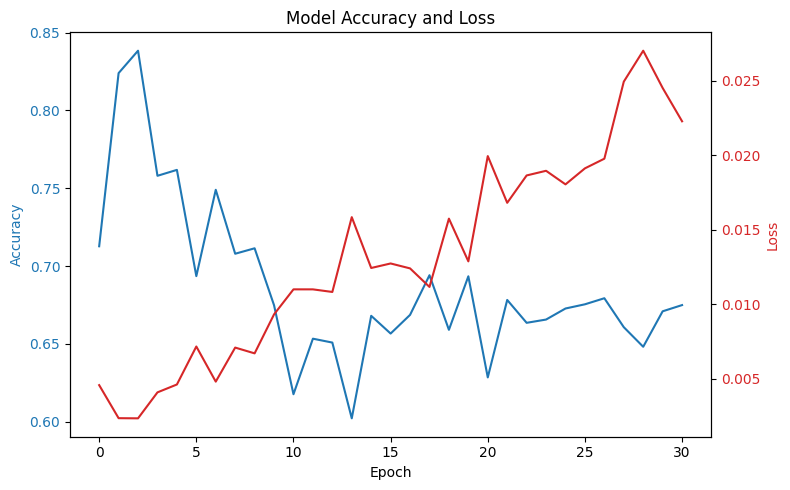

In [25]:
import matplotlib.pyplot as plt

#Plot val acc and loss
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on primary y
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the loss on secondary y
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()

In [52]:
torch.save(model, './model_saves/model_complete.pth')

In [26]:
del model

In [27]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

In [28]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [27]:
from numba import cuda
 
cuda.select_device(0) # choosing second GPU 
cuda.close()

In [36]:
device = cuda.get_current_device()
device.reset()
cuda.close()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 3080 Laptop GPU''>
